In [42]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [43]:
train_path = "../data/KDDTrain+.txt"
test_path = "../data/KDDTest+.txt"

# Load without headers
df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

In [44]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (125973, 43)
Test shape: (22544, 43)


In [5]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label", "difficulty_level"  
]


In [6]:
df_train.columns = columns
df_test.columns = columns

In [7]:
categorical_cols = ["protocol_type", "service", "flag"]

le = LabelEncoder()
for col in categorical_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [8]:
numeric_cols = ["duration", "src_bytes", "dst_bytes"]

scaler = MinMaxScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [9]:
df_train.to_csv("../data/train_preprocessed.csv", index=False)
df_test.to_csv("../data/test_preprocessed.csv", index=False)

<Axes: title={'center': 'Attack Type Distribution'}, xlabel='label'>

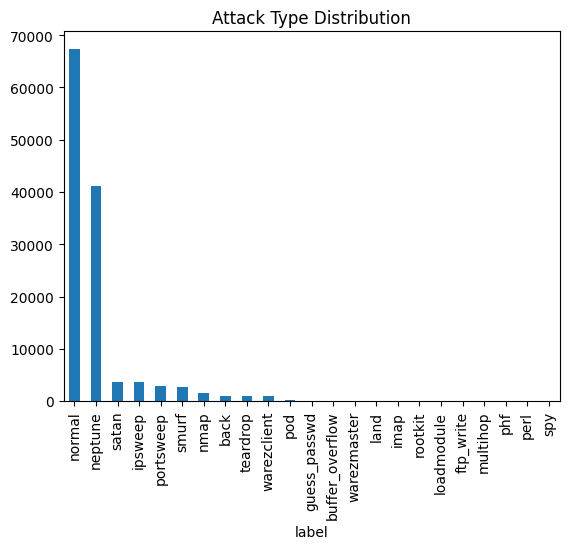

In [10]:
df_train['label'].value_counts().plot(kind='bar', title='Attack Type Distribution')


In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data first (stratify maintains distribution in test set)
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop('label', axis=1),
    df_train['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
import pandas as pd
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_resampled).value_counts())



ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3

In [12]:
from collections import Counter
print("Original class distribution:", Counter(y_train))


Original class distribution: Counter({'normal': 53874, 'neptune': 32971, 'satan': 2906, 'ipsweep': 2879, 'portsweep': 2345, 'smurf': 2117, 'nmap': 1194, 'back': 765, 'teardrop': 714, 'warezclient': 712, 'pod': 161, 'guess_passwd': 42, 'buffer_overflow': 24, 'warezmaster': 16, 'land': 14, 'imap': 9, 'rootkit': 8, 'loadmodule': 7, 'multihop': 6, 'ftp_write': 6, 'perl': 3, 'phf': 3, 'spy': 2})


In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Check class distribution in y_train
class_counts = Counter(y_train)
print("Original class distribution:", class_counts)

# Step 2: Automatically choose a safe value for k_neighbors
minority_class = min(class_counts, key=class_counts.get)
minority_count = class_counts[minority_class]

# k_neighbors must be less than or equal to (minority_count - 1)
k_neighbors = max(1, min(5, minority_count - 1))
print(f"Using k_neighbors={k_neighbors} for SMOTE")

# Step 3: Apply SMOTE on training data
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Confirm the new class distribution
resampled_counts = Counter(y_train_resampled)
print("Resampled class distribution:", resampled_counts)



Original class distribution: Counter({'normal': 53874, 'neptune': 32971, 'satan': 2906, 'ipsweep': 2879, 'portsweep': 2345, 'smurf': 2117, 'nmap': 1194, 'back': 765, 'teardrop': 714, 'warezclient': 712, 'pod': 161, 'guess_passwd': 42, 'buffer_overflow': 24, 'warezmaster': 16, 'land': 14, 'imap': 9, 'rootkit': 8, 'loadmodule': 7, 'multihop': 6, 'ftp_write': 6, 'perl': 3, 'phf': 3, 'spy': 2})
Using k_neighbors=1 for SMOTE
Resampled class distribution: Counter({'neptune': 53874, 'normal': 53874, 'satan': 53874, 'nmap': 53874, 'teardrop': 53874, 'smurf': 53874, 'warezclient': 53874, 'ipsweep': 53874, 'portsweep': 53874, 'back': 53874, 'pod': 53874, 'guess_passwd': 53874, 'multihop': 53874, 'buffer_overflow': 53874, 'rootkit': 53874, 'warezmaster': 53874, 'ftp_write': 53874, 'loadmodule': 53874, 'imap': 53874, 'land': 53874, 'perl': 53874, 'phf': 53874, 'spy': 53874})


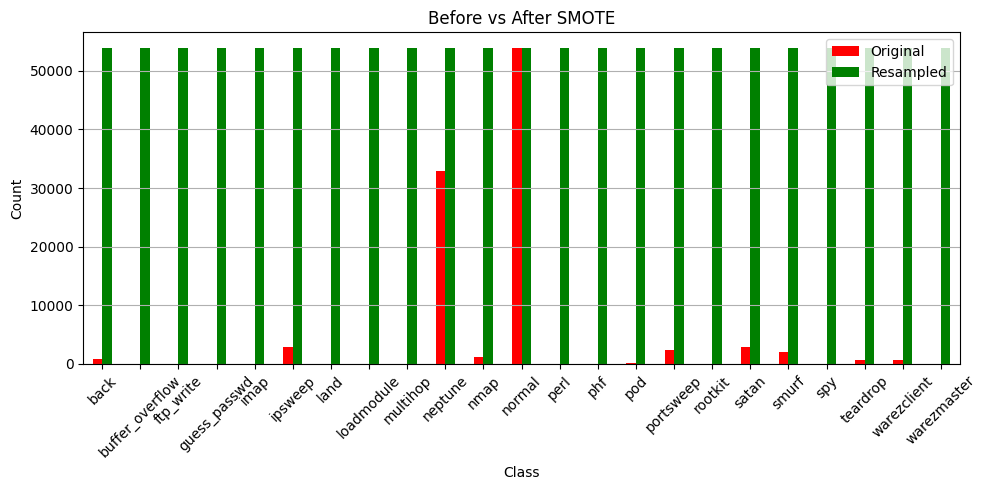

In [34]:
import matplotlib.pyplot as plt
# Original
original_series = pd.Series(y_train)
original_counts = original_series.value_counts()

# Resampled
resampled_series = pd.Series(y_train_resampled)
resampled_counts = resampled_series.value_counts()

# Combine into DataFrame
comparison_df = pd.DataFrame({
    'Original': original_counts,
    'Resampled': resampled_counts
})

comparison_df.plot(kind='bar', title='Before vs After SMOTE', figsize=(10, 5), color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


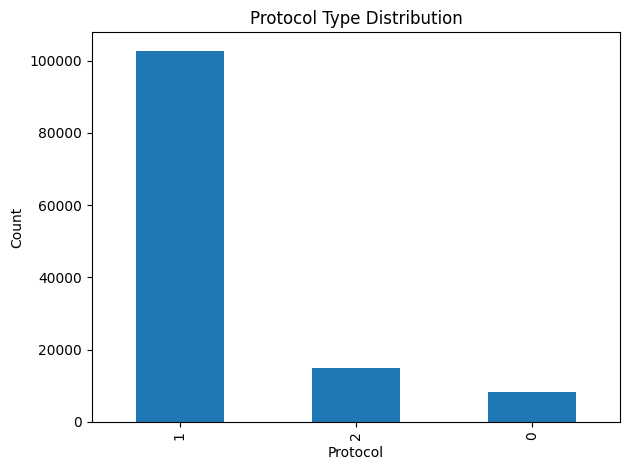

In [14]:
import matplotlib.pyplot as plt

df_train['protocol_type'].value_counts().plot(kind='bar', title='Protocol Type Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


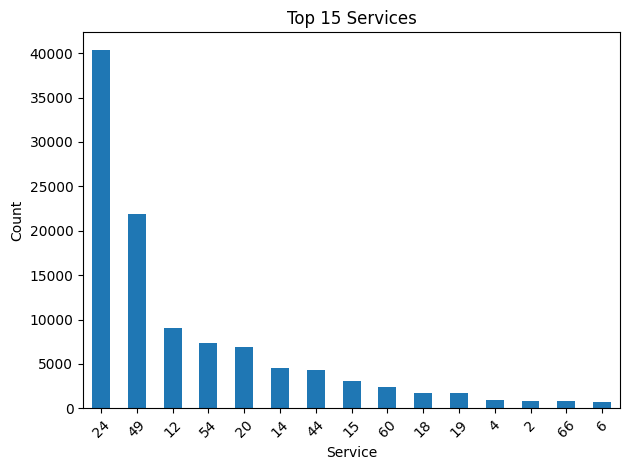

In [14]:
df_train['service'].value_counts().nlargest(15).plot(kind='bar', title='Top 15 Services')
plt.xlabel('Service')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


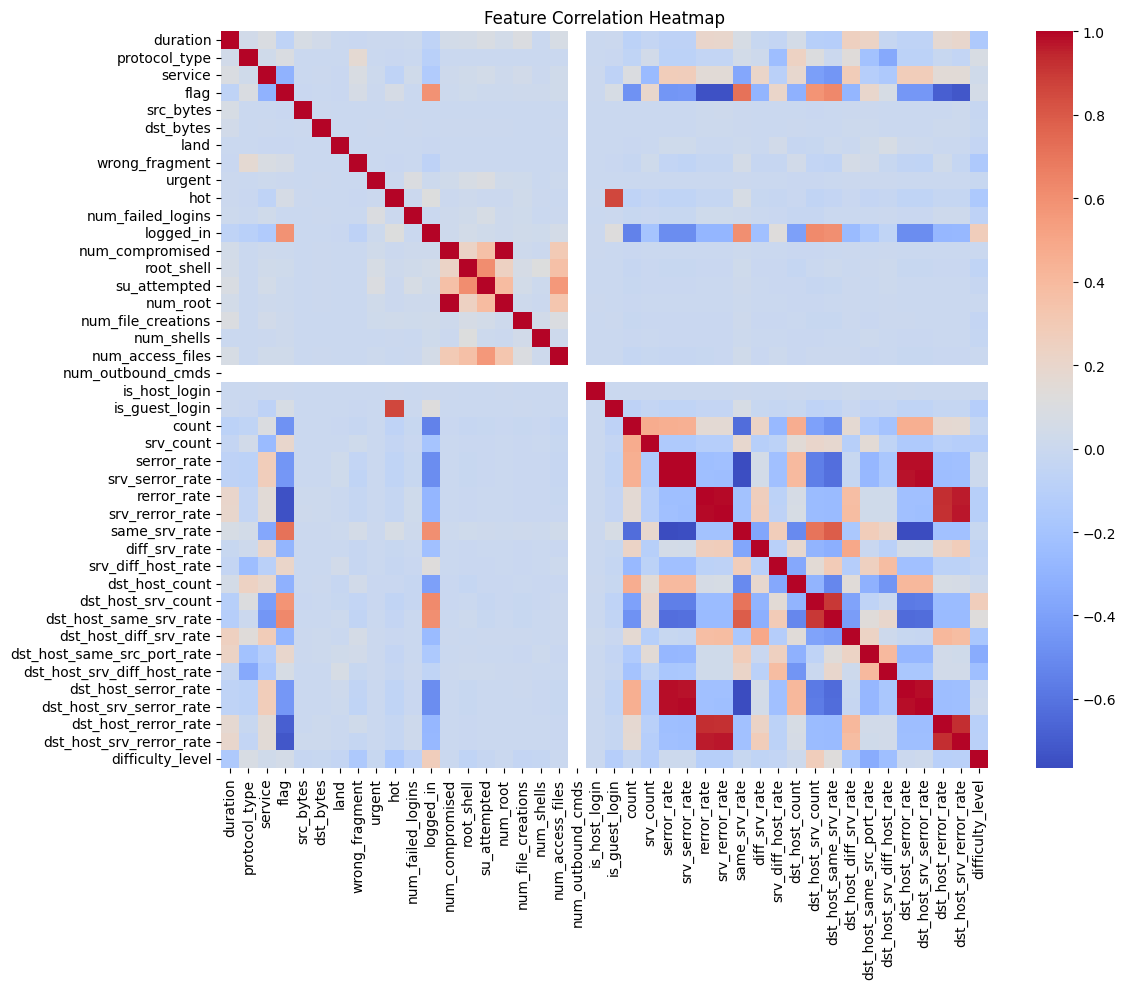

In [18]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_train.select_dtypes(include=['float64', 'int64']).corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Sample 20% of the resampled training data for faster experimentation
import pandas as pd

X_sampled = pd.DataFrame(X_train_resampled).sample(frac=0.2, random_state=42)
y_sampled = y_train_resampled[X_sampled.index]



In [1]:
!where python 

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\Scripts\python.exe
C:\Users\hrish\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\hrish\AppData\Local\Microsoft\WindowsApps\python.exe


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

lr_model = LogisticRegression(max_iter=200)  # Lower max_iter
lr_model.fit(X_sampled, y_sampled)

y_pred_lr = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))


Accuracy: 0.8171462591784084
F1 Score: 0.852514411854691


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train[:20000], y_train[:20000])  # Use just 20k records
y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9304227029172455


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8171462591784084
Logistic Regression F1 Score: 0.852514411854691


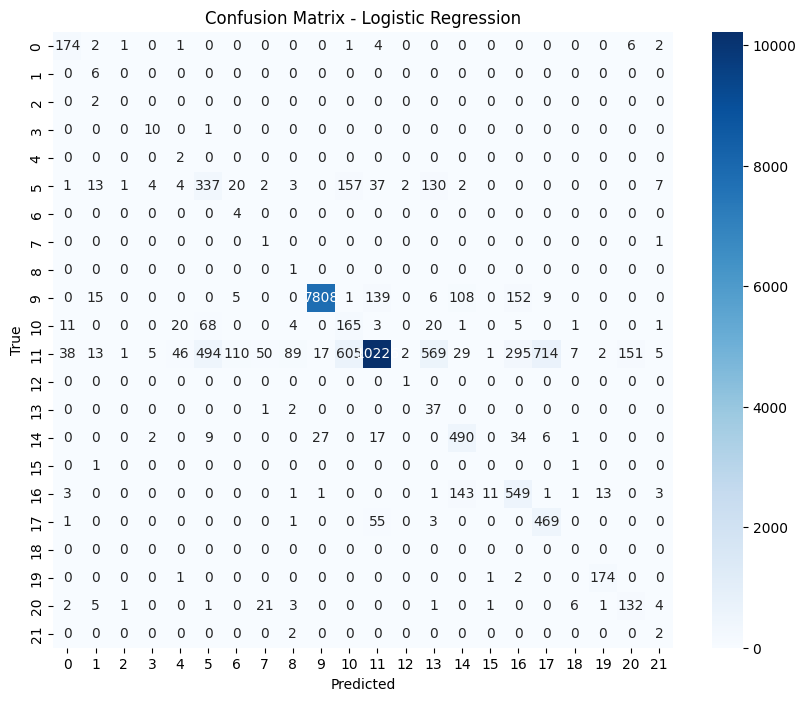

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_sampled, y_sampled)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))
plot_confusion(y_test, y_pred_lr, "Logistic Regression")


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))


                 precision    recall  f1-score   support

           back       0.76      0.91      0.83       191
buffer_overflow       0.11      1.00      0.19         6
      ftp_write       0.00      0.00      0.00         2
   guess_passwd       0.48      0.91      0.62        11
           imap       0.03      1.00      0.05         2
        ipsweep       0.37      0.47      0.41       720
           land       0.03      1.00      0.06         4
     loadmodule       0.01      0.50      0.03         2
       multihop       0.01      1.00      0.02         1
        neptune       0.99      0.95      0.97      8243
           nmap       0.18      0.55      0.27       299
         normal       0.98      0.76      0.85     13469
            phf       0.20      1.00      0.33         1
            pod       0.05      0.93      0.09        40
      portsweep       0.63      0.84      0.72       586
        rootkit       0.00      0.00      0.00         2
          satan       0.53    

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Naive Bayes Accuracy: 0.6853740821591585
Naive Bayes F1 Score: 0.7471414147755365


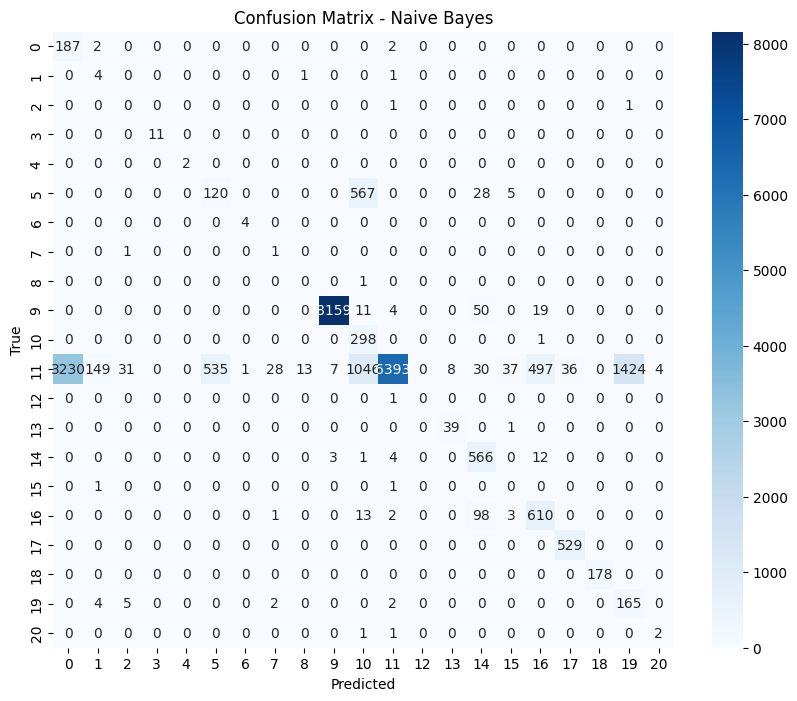

                 precision    recall  f1-score   support

           back       0.05      0.98      0.10       191
buffer_overflow       0.03      0.67      0.05         6
      ftp_write       0.00      0.00      0.00         2
   guess_passwd       1.00      1.00      1.00        11
           imap       1.00      1.00      1.00         2
        ipsweep       0.18      0.17      0.17       720
           land       0.80      1.00      0.89         4
     loadmodule       0.03      0.50      0.06         2
       multihop       0.00      0.00      0.00         1
        neptune       1.00      0.99      0.99      8243
           nmap       0.15      1.00      0.27       299
         normal       1.00      0.47      0.64     13469
            phf       0.00      0.00      0.00         1
            pod       0.83      0.97      0.90        40
      portsweep       0.73      0.97      0.83       586
        rootkit       0.00      0.00      0.00         2
          satan       0.54    

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [33]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_sampled, y_sampled)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
plot_confusion(y_test, y_pred_nb, "Naive Bayes")

#repoer 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nb))

                 precision    recall  f1-score   support

           back       0.05      0.98      0.10       191
buffer_overflow       0.03      0.67      0.05         6
      ftp_write       0.00      0.00      0.00         2
   guess_passwd       1.00      1.00      1.00        11
           imap       1.00      1.00      1.00         2
        ipsweep       0.18      0.17      0.17       720
           land       0.80      1.00      0.89         4
     loadmodule       0.03      0.50      0.06         2
       multihop       0.00      0.00      0.00         1
        neptune       1.00      0.99      0.99      8243
           nmap       0.15      1.00      0.27       299
         normal       1.00      0.47      0.64     13469
            phf       0.00      0.00      0.00         1
            pod       0.83      0.97      0.90        40
      portsweep       0.73      0.97      0.83       586
        rootkit       0.00      0.00      0.00         2
          satan       0.54    

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Decision Tree Accuracy: 0.8612026195673744
Decision Tree F1 Score: 0.9052573090764936


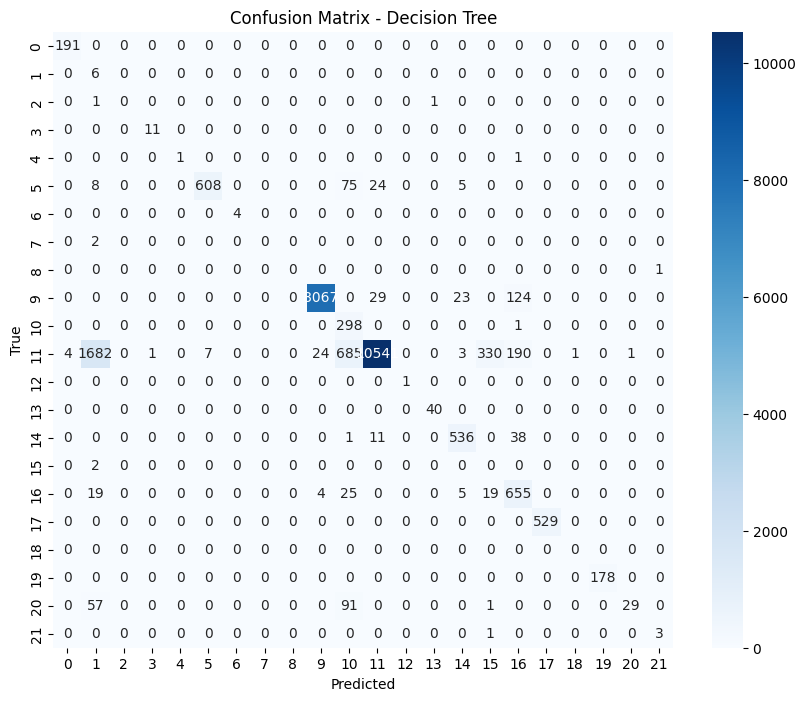


Basic Decision Tree Classification Report:
                 precision    recall  f1-score   support

           back       0.98      1.00      0.99       191
buffer_overflow       0.00      1.00      0.01         6
      ftp_write       0.00      0.00      0.00         2
   guess_passwd       0.92      1.00      0.96        11
           imap       1.00      0.50      0.67         2
        ipsweep       0.99      0.84      0.91       720
           land       1.00      1.00      1.00         4
     loadmodule       0.00      0.00      0.00         2
       multihop       0.00      0.00      0.00         1
        neptune       1.00      0.98      0.99      8243
           nmap       0.25      1.00      0.40       299
         normal       0.99      0.78      0.88     13469
            phf       1.00      1.00      1.00         1
            pod       0.98      1.00      0.99        40
      portsweep       0.94      0.91      0.93       586
        rootkit       0.00      0.00      0

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [37]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10 , random_state=42)  # Speed up with limited depth
dt_model.fit(X_sampled, y_sampled)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))
plot_confusion(y_test, y_pred_dt, "Decision Tree")

from sklearn.metrics import classification_report
print("\nBasic Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted')
    }

results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr))
results.append(evaluate_model("Naive Bayes", y_test, y_pred_nb))
results.append(evaluate_model("Decision Tree", y_test, y_pred_dt))

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 Model  Accuracy  F1 Score  Precision    Recall
0  Logistic Regression  0.817146  0.852514   0.913571  0.817146
1          Naive Bayes  0.685374  0.747141   0.929233  0.685374
2        Decision Tree  0.861441  0.905497   0.974003  0.861441


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



TUNED DECISION TREE
Starting GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.9996085937551396
Tuned Decision Tree Accuracy: 0.9977773367731693
Tuned Decision Tree F1 Score: 0.9977593270142956

Tuned Decision Tree Classification Report:


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                 precision    recall  f1-score   support

           back       0.99      1.00      1.00       191
buffer_overflow       1.00      1.00      1.00         6
      ftp_write       1.00      0.50      0.67         2
   guess_passwd       1.00      1.00      1.00        11
           imap       1.00      1.00      1.00         2
        ipsweep       0.99      0.98      0.99       720
           land       1.00      1.00      1.00         4
     loadmodule       1.00      0.50      0.67         2
       multihop       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00      8243
           nmap       0.96      1.00      0.98       299
         normal       1.00      1.00      1.00     13469
            phf       1.00      1.00      1.00         1
            pod       1.00      1.00      1.00        40
      portsweep       1.00      0.99      0.99       586
        rootkit       0.00      0.00      0.00         2
          satan       0.99    

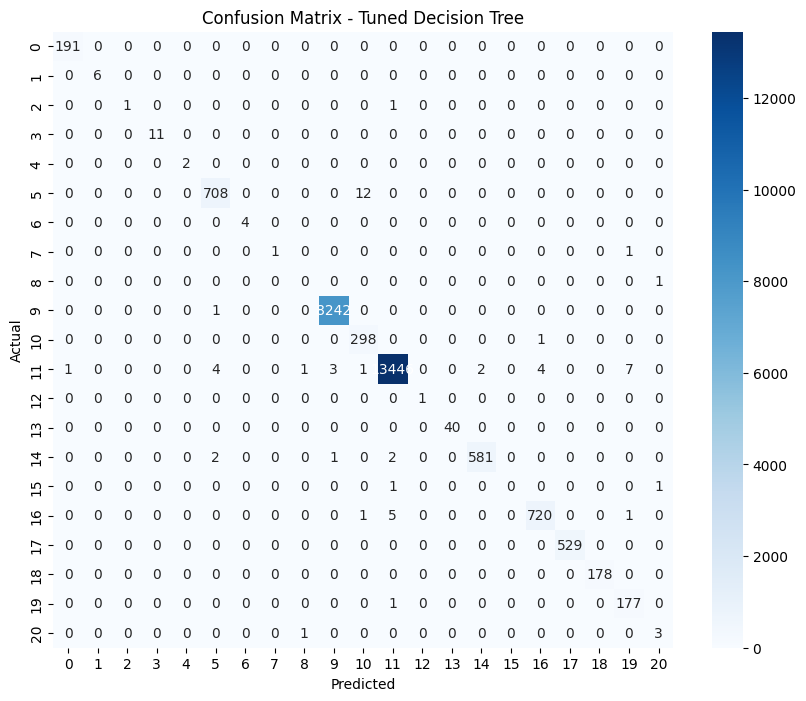

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*50)
print("TUNED DECISION TREE")
print("="*50)

# Define the parameter grid
param_grid = {
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}


# Initialize the model
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=3,
                           n_jobs=-1,  # Use all cores for speed
                           verbose=1)

# Fit on full resampled training data
print("Starting GridSearchCV...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_dt = grid_search.best_estimator_



# Predict and evaluate
y_pred_best = best_dt.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)
print("Tuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned Decision Tree F1 Score:", f1_score(y_test, y_pred_best, average='weighted'))

print("\nTuned Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_best))

# Optional: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted')
    }

# Collect results
results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr))
results.append(evaluate_model("Naive Bayes", y_test, y_pred_nb))
results.append(evaluate_model("Decision Tree", y_test, y_pred_dt))
results.append(evaluate_model("Tuned Decision Tree", y_test, y_pred_best))  # ✅ Add this

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(df_results)


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                 Model  Accuracy  F1 Score  Precision    Recall
0  Logistic Regression  0.817146  0.852514   0.913571  0.817146
1          Naive Bayes  0.685374  0.747141   0.929233  0.685374
2        Decision Tree  0.861441  0.905497   0.974003  0.861441
3  Tuned Decision Tree  0.997777  0.997759   0.997789  0.997777


C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


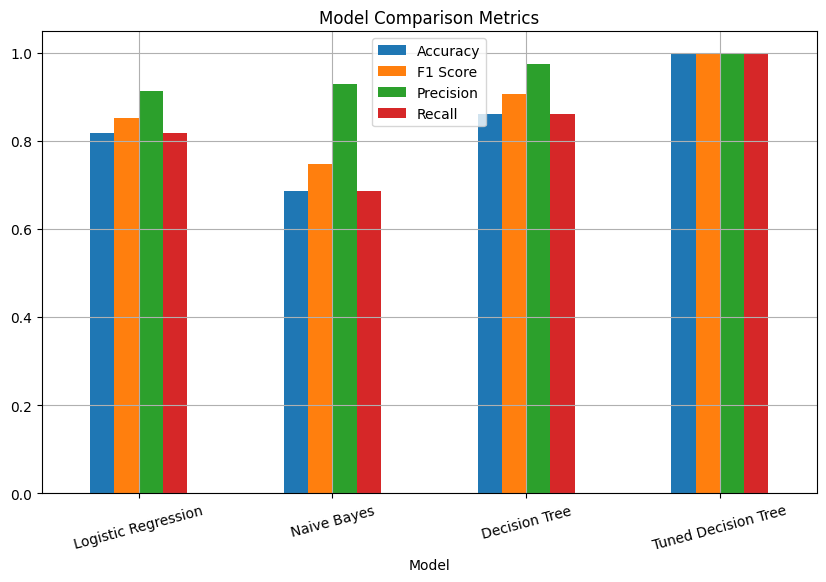

In [40]:
df_results.plot(x="Model", kind="bar", figsize=(10, 6), title="Model Comparison Metrics", rot=15)
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import accuracy_score

# Predict on training and test sets
y_train_pred = best_dt.predict(X_train_resampled)
y_test_pred = best_dt.predict(X_test)

# Accuracy on training set
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Accuracy on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9997546610367831
Test Accuracy: 0.9977773367731693


In [42]:
from sklearn.metrics import classification_report

print("\nTraining Classification Report:\n")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTest Classification Report:\n")
print(classification_report(y_test, y_test_pred))



Training Classification Report:

                 precision    recall  f1-score   support

           back       1.00      1.00      1.00     53874
buffer_overflow       1.00      1.00      1.00     53874
      ftp_write       1.00      1.00      1.00     53874
   guess_passwd       1.00      1.00      1.00     53874
           imap       1.00      1.00      1.00     53874
        ipsweep       1.00      1.00      1.00     53874
           land       1.00      1.00      1.00     53874
     loadmodule       1.00      1.00      1.00     53874
       multihop       1.00      1.00      1.00     53874
        neptune       1.00      1.00      1.00     53874
           nmap       0.99      1.00      1.00     53874
         normal       1.00      1.00      1.00     53874
           perl       1.00      1.00      1.00     53874
            phf       1.00      1.00      1.00     53874
            pod       1.00      1.00      1.00     53874
      portsweep       1.00      1.00      1.00     53

C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hrish\OneDrive\Desktop\P-NID system\NIDS\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [39]:
import pandas as pd

print("\n" + "="*50)
print("MISCLASSIFICATION ANALYSIS")
print("="*50)

# Convert X_test to DataFrame with proper column names
if hasattr(X_test, 'columns'):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Reset indices to ensure alignment
X_test_df = X_test_df.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True) if hasattr(y_test, 'reset_index') else pd.Series(y_test)

# Find misclassified samples
misclassified_mask = y_test_reset != y_pred_best
misclassified = X_test_df[misclassified_mask].copy()

# Add actual and predicted labels
misclassified['actual'] = y_test_reset[misclassified_mask].values
misclassified['predicted'] = y_pred_best[misclassified_mask]


# Save to CSV
misclassified.to_csv("misclassified_records_tuned_dt.csv", index=False)
print("✅ Misclassified samples saved to 'misclassified_records_tuned_dt.csv'")





MISCLASSIFICATION ANALYSIS
✅ Misclassified samples saved to 'misclassified_records_tuned_dt.csv'


In [40]:
print(f"\nTotal test samples: {len(y_test)}")
print(f"Misclassified samples: {len(misclassified)}")
print(f"Accuracy: {(len(y_test) - len(misclassified)) / len(y_test) * 100:.2f}%")

# Show distribution of misclassified samples by actual class
print("\nMisclassification by actual class:")
misclass_by_actual = misclassified['actual'].value_counts()
print(misclass_by_actual)

# Show distribution of misclassified samples by predicted class
print("\nMisclassification by predicted class:")
misclass_by_predicted = misclassified['predicted'].value_counts()
print(misclass_by_predicted)

# Show some examples of misclassified samples
print("\nFirst 5 misclassified samples:")
print(misclassified[['actual', 'predicted']].head())



Total test samples: 25195
Misclassified samples: 56
Accuracy: 99.78%

Misclassification by actual class:
actual
normal         23
ipsweep        12
satan           7
portsweep       5
rootkit         2
multihop        1
warezclient     1
nmap            1
neptune         1
ftp_write       1
warezmaster     1
loadmodule      1
Name: count, dtype: int64

Misclassification by predicted class:
predicted
nmap           14
normal         10
warezclient     9
ipsweep         7
satan           5
neptune         4
warezmaster     2
multihop        2
portsweep       2
back            1
Name: count, dtype: int64

First 5 misclassified samples:
       actual    predicted
753   rootkit  warezmaster
909    normal      neptune
996    normal  warezclient
1072  ipsweep         nmap
1075   normal        satan



FEATURE IMPORTANCE (Top 10)
                        feature  importance
5                     dst_bytes    0.128681
4                     src_bytes    0.108839
41             difficulty_level    0.095484
2                       service    0.057106
11                    logged_in    0.046024
36  dst_host_srv_diff_host_rate    0.045501
6                          land    0.045464
7                wrong_fragment    0.045169
33       dst_host_same_srv_rate    0.045153
10            num_failed_logins    0.044270


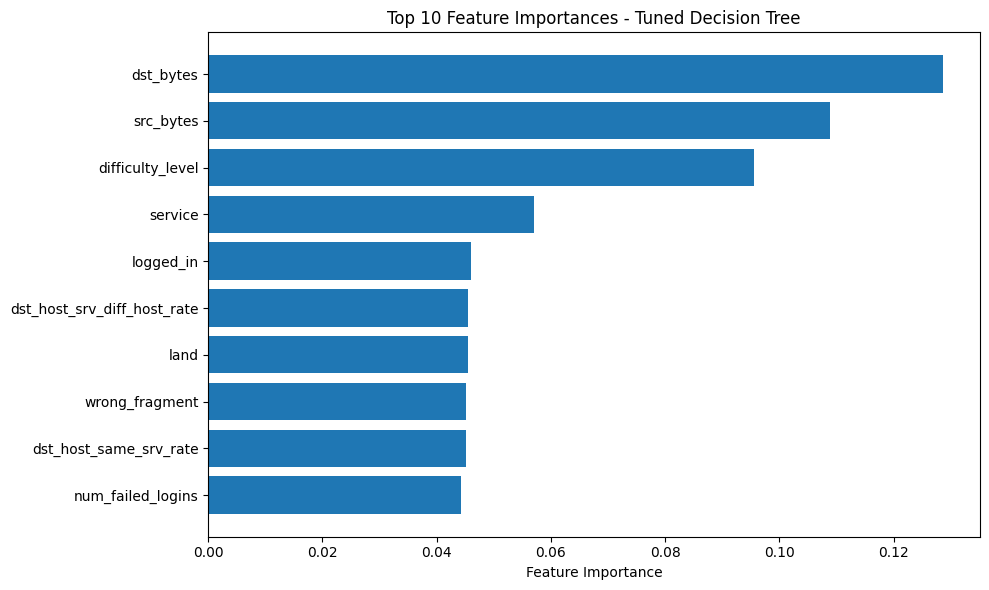


ANALYSIS COMPLETE


In [41]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE (Top 10)")
print("="*50)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Tuned Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

In [45]:

# Save the tuned model to a file
joblib.dump(best_dt, "tuned_decision_tree_model.pkl")
print("✅ Tuned Decision Tree saved as 'tuned_decision_tree_model.pkl'")


✅ Tuned Decision Tree saved as 'tuned_decision_tree_model.pkl'
